In [ ]:
%run util/installers.ipynb

### Overview
* <a href="#section1">What is a grammar, how does ambiguity emerge?</a>
* <a href="#section2">What is dependency grammar?</a>
    * contrast with constituency/CFG
    * mention the assumptions of DG, any issues there
    * briefly mention the shift-reduce parsing method SpaCy uses
* <a href="#section3">why is it useful?</a>
    * deal with languages with free word order
        * phrase structure rules/constituency parsers explode with rules.
        * eg NP -> ADJ NN and NN ADJ
    * applications: 
        * Grammar checker
        * chunking for information retrieval: 
            * which words modify the noun or verb?
            * extract noun phrases, verb phrases, adjective phrases, and prepositional phrases
            * see <a href="#relationextractor">example</a>
        * question answering 
        * feature engineering for: 
            * coreference resolution
                * When Bob goes to the movies [he] likes to buy popcorn with extra butter.          
            * machine translation:
                * "Bob goes" -> subject verb -> "Bob va"
* <a href="#section4"> Dependency Grammar with SpaCy:</a>
    * Traversing paths
    * Grabbing entities
    * Exercise:
        * extract all noun phrases from a sentence

In [3]:
from IPython.display import HTML
from assets.static_html import syntax
HTML(syntax)

In [4]:
from assets.static_html import morphology
HTML(morphology)

,Effect,Morpheme
,,
un,Negation,Prefix
reach,Verb,Root
able,To Adjective,Suffix


In [5]:
from assets.static_html import morph_and_syntax
HTML(morph_and_syntax)

# Models of Grammar

In [7]:
from assets.static_html import valency
HTML(valency)

### Context Free Grammar, production rules

|Root| |Components |
|-----||---------------------------------------|
| S   |$\rightarrow$|NP VP                                 |
| NP |$\rightarrow$| Pron or PropN or Det Nom   |
| VP  |$\rightarrow$|V or V NP or V NP NN or V PP |
| PP  |$\rightarrow$|Prep NP                        |
| etc |$\rightarrow$|etc                                   |

### Constituency and Dependency Grammars

In [8]:
from IPython.display import Image
Image(url='https://upload.wikimedia.org/wikipedia/commons/8/8e/Thistreeisillustratingtherelation%28PSG%29.png')

In [9]:
from assets.static_html import dep_axioms
HTML(dep_axioms)

<a name="section3"</a>
### Applications of DG

In [23]:
from util.util import displacy
displacy('He and Sally order it once a week')

<a name="section4"></a>
### DG with SpaCy

In [12]:
from IPython.display import HTML
from assets.static_html import accessing_dependents
HTML(accessing_dependents)

In [28]:
from util.util import displacy
displacy("Harry and little Sally like to eat", width=1500, height=500)

### Examples

In [3]:
import spacy
nlp = spacy.load('en')

### Simple Relation Extractor

In [137]:
def is_verb(token):
    return token.pos_ == 'VERB'

def is_nsubj(token):
    return token.dep_ == 'nsubj'

def is_property(token):
    return token.dep_ in ('attr','acomp','dobj','pobj','prep')
    
def subtree(token):
    return list(map(lambda x: x.orth_, token.subtree))

def extract_relations(sentence):
    relations = []
    for VERB in filter(is_verb,sentence):
        for SUBJECT in filter(is_nsubj, VERB.children):
            for PROPERTY in filter(is_property, VERB.children):
                PROPERTY_SUBTREE = PROPERTY.doc[PROPERTY.left_edge.i:PROPERTY.right_edge.i+1]
                SUBJECT_SUBTREE = SUBJECT.doc[SUBJECT.left_edge.i:SUBJECT.right_edge.i+1]
                yield {'subject root':SUBJECT, 
                       'subject_subtree': SUBJECT_SUBTREE,
                       'property root':PROPERTY, 
                       'property_subtree': PROPERTY_SUBTREE,
                       'relation root':VERB, 
                       }

text = 'When using Jupyter, one executes code in cells. '
doc = nlp(text)
list(extract_relations(doc))

[{'property root': code,
  'property_subtree': code in cells,
  'relation root': executes,
  'subject root': one,
  'subject_subtree': one}]

In [139]:
list(extract_relations(nlp("When prototyping NLP solutions, Jupyter speeds up development time.")))

[{'property root': time,
  'property_subtree': development time,
  'relation root': speeds,
  'subject root': Jupyter,
  'subject_subtree': Jupyter}]

In [142]:
text = """
This coffee is very smooth and flavorful. 
I will be buying more as gifts and more for myself. 
I like this company and will be seeing what other flavors I can check out. 
So glad I took a chance on this coffee.
"""
list(extract_relations(nlp(text)))

[{'property root': smooth,
  'property_subtree': very smooth and flavorful,
  'relation root': is,
  'subject root': coffee,
  'subject_subtree': 
  This coffee},
 {'property root': more,
  'property_subtree': more as gifts and more for myself,
  'relation root': buying,
  'subject root': I,
  'subject_subtree': I},
 {'property root': company,
  'property_subtree': this company,
  'relation root': like,
  'subject root': I,
  'subject_subtree': I},
 {'property root': flavors,
  'property_subtree': what other flavors,
  'relation root': check,
  'subject root': I,
  'subject_subtree': I},
 {'property root': chance,
  'property_subtree': a chance on this coffee,
  'relation root': took,
  'subject root': I,
  'subject_subtree': I}]

### Exercise 2:
Build a function that collects all descriptions of python.

##### Method
Method: collect all dependent clauses of "equivalence" verbs where python is the subject.
E.g: Python is <u>great</u>




##### Components:
* a matcher with an entity PYTHON, with an associated pattern for PYTHON (my_python_pattern)
* an nlp pipeline that uses the custom matcher.

* a function that filters all the relations found in text to those that make equivalence statements about Python (get_relations).


In [145]:
# Our data:
!pip install wikipedia >> ~/wikilog.txt
import wikipedia
page = wikipedia.page("Python_(programming_language)").content

In [175]:
from spacy.matcher import Matcher
from spacy import attrs

def merge_matches(matcher, doc, i, matches):
    '''
    Merge a phrase. We have to be careful here because we'll change the token indices.
    To avoid problems, merge all the phrases once we're called on the last match.
    '''
    if i != len(matches)-1:
        return None

    spans = [(ent_id, label, doc[start : end]) for ent_id, label, start, end in matches]
    for ent_id, label, span in spans:
        span.merge(label=label, tag='NNP' if label else span.root.tag_)


# DEFINE my_python_pattern        
#this should be a list of dictionaries, where each dictionary is {TOKEN PROPERTY: TOKEN VALUE}
#PROPERTIES are found in spacy.attrs, e.g. POS
my_python_pattern = [{attrs.LOWER:'python'}]        


matcher = Matcher(nlp.vocab)
matcher.add_entity("PYTHON", on_match = merge_matches)
matcher.add_pattern("PYTHON", my_python_pattern, label='Python')
nlp.pipeline = [nlp.tagger, nlp.parser, matcher, nlp.entity]



def is_python_property(relation):
    """
    Determines whether the given relation, e.g.:
        { 'property root': big,
          'property_subtree': really big,
          'relation root': is,
          'subject root': ecosystem,
          'subject_subtree': the python ecosystem 
        }
        
    follows: [python] [be/have] [property]
    i.e.
        
    ### A) have python has a subject
    ### B) relate python with an equivalence_verb (e.g. "be")
    ### note to get normalized "be" from is, are, etc, use token.lemma_    
    
    Returns Boolean
    """
    
    equivalence_verbs = ['be']
    
    property_root = relation['property root']
    property_subtree = relation['property_subtree']
    relation_root = relation['relation root']
    subject_root = relation['subject root']
    subject_subtree = relation['subject_subtree']
    
    if subject_root.ent_type_ == 'Python':
        if relation_root.lemma_ in equivalence_verbs:
            return True
        
    
    return False
    
    

def get_all_properties_of_python(text):
    """Converts text to document, and extracts all relations that define python equivalences"""
    doc = nlp(text)
    python_properties = []
    for relation in extract_relations(doc):
        if is_python_property(relation):
            python_properties.append(relation)
    return python_properties


get_all_properties_of_python(page)

[{'property root': language,
  'property_subtree': a widely used high-level programming language for general-purpose programming, created by Guido van Rossum and first released in 1991,
  'relation root': is,
  'subject root': Python,
  'subject_subtree': Python},
 {'property root': language,
  'property_subtree': a multi-paradigm programming language,
  'relation root': is,
  'subject root': Python,
  'subject_subtree': Python},
 {'property root': fork,
  'property_subtree': a significant fork of CPython that implements microthreads,
  'relation root': is,
  'subject root': Python,
  'subject_subtree': Stackless Python}]

### Appendix:

Cool application of Dependency Parsing:

* www.aclweb.org/anthology/P15-2029


Capturing sentences as graphs...

In [4]:
import networkx


def doc_to_graph(doc):

    def sent_graph(token, graph, i):
            
        graph.add_node(token.i + i, {"label":token.orth_})
        
        for child in token.children:
            sent_graph(child, graph, i)
            graph.add_edge(token.i + i, child.i + i, {'label':child.dep_})
        return graph
    
    graph = networkx.DiGraph()
    
    for sent in doc.sents:
        graph = sent_graph(sent.root, graph, len(graph))
    
    return graph


doc = nlp("I like to eat cake. And sometimes I eat pie too.")
g = doc_to_graph(doc)


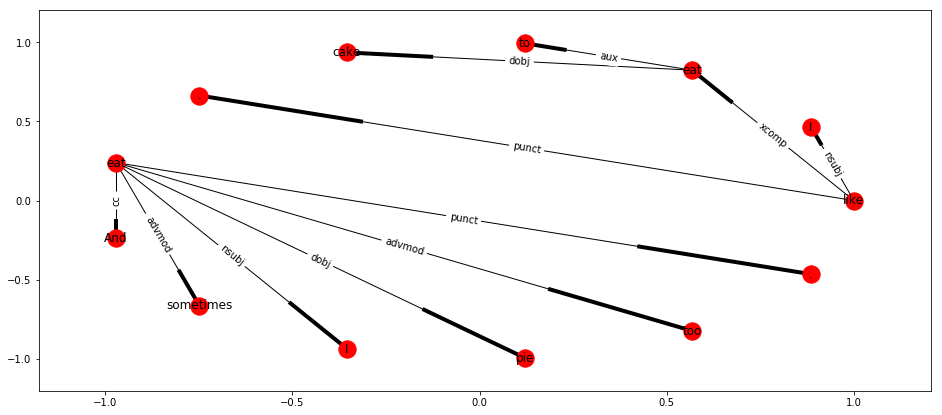

In [132]:
import matplotlib.pyplot as plt
%matplotlib inline

edge_labels = networkx.get_edge_attributes(g, 'label')
node_labels = networkx.get_node_attributes(g, 'label')
pos = networkx.shell_layout(g)

f, ax = plt.subplots(1, figsize = (16, 7))
networkx.draw_networkx(g, pos=pos, labels=node_labels)
edges = networkx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels)